In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib

import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
data_normal_1 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_normal_1.csv')
data_normal_2 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_normal_2.csv')

data_attack_1 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_attack_1.csv')
data_attack_2 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_attack_2.csv')

In [3]:
data_normal_1.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url',
       'timeout', 'label']
data_normal_2.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url',
       'timeout', 'label']

data_attack_1.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url',
       'timeout', 'label']
data_attack_2.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url',
       'timeout', 'label']

In [4]:
features = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url', 'timeout']

In [5]:
X_normal_1 = data_normal_1[features].values
X_normal_2 = data_normal_2[features].values

X_attack_1 = data_attack_1[features].values
X_attack_2 = data_attack_2[features].values

Y_normal_1 = data_normal_1['label']
Y_normal_2 = data_normal_2['label']

Y_attack_1 = data_attack_1['label']
Y_attack_2 = data_attack_2['label']

X=np.concatenate((X_normal_1,X_normal_2,X_attack_1,X_attack_2))
Y=np.concatenate((Y_normal_1,Y_normal_2,Y_attack_1,Y_attack_2))

In [6]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [7]:
print(np.shape(X))
print(np.shape(Y))

(10464, 7)
(10464,)


In [8]:
features = len(X[0])
samples = X.shape[0]
train_len = 200
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

In [9]:
for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [10]:
print(I.shape)

(10264, 200, 7)


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[200:], test_size = 0.2, stratify=Y[200:], random_state = 0)

In [12]:
def create_baseline():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [13]:
model = create_baseline()

In [14]:
checkpoint = ModelCheckpoint("LSTMmodel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [15]:
history = model.fit(X_train, Y_train, epochs = 30,validation_split=0.2, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/30
206/206 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.9840
Epoch 00001: val_loss improved from inf to 0.06232, saving model to LSTMmodel.h5
206/206 [==============================] - 10s 31ms/step - loss: 0.5072 - accuracy: 0.9840 - val_loss: 0.0623 - val_accuracy: 0.9988
Epoch 2/30
204/206 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9965
Epoch 00002: val_loss improved from 0.06232 to 0.03748, saving model to LSTMmodel.h5
206/206 [==============================] - 6s 28ms/step - loss: 0.0490 - accuracy: 0.9965 - val_loss: 0.0375 - val_accuracy: 0.9988
Epoch 3/30
205/206 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9960 ETA: 0s - loss: 0.0462 - accu
Epoch 00003: val_loss did not improve from 0.03748
206/206 [==============================] - 6s 27ms/step - loss: 0.0463 - accuracy: 0.9960 - val_loss: 0.0446 - val_accuracy: 0.9988
Epoch 4/30
204/206 [============================>.] - ETA: 0s - loss

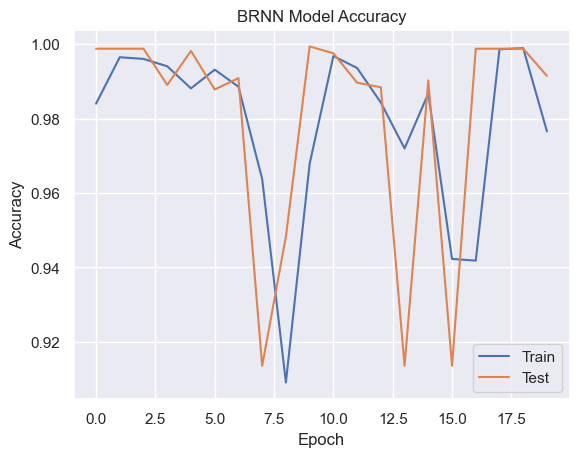

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

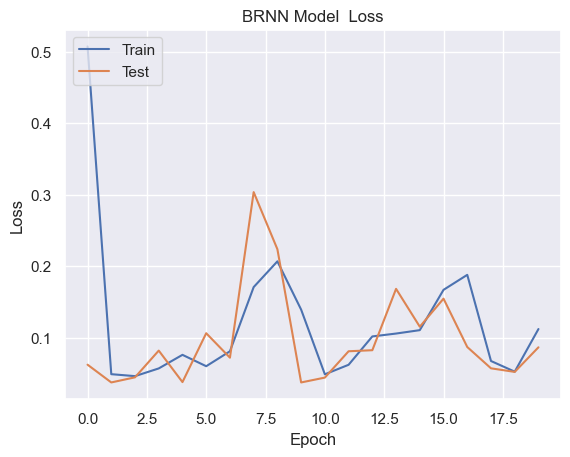

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [18]:
predict = model.predict(X_test, verbose=1)

65/65 [==============================] - 1s 13ms/step


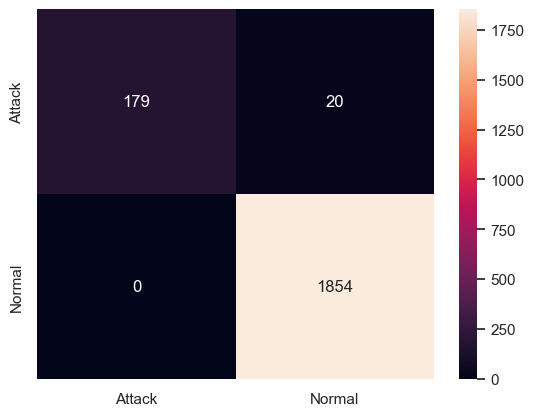

In [19]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [20]:
figure = ax.get_figure()
figure.savefig('confusion_matrix_BRNN_200.png', dpi=400)

In [21]:
# model.save('brnn_model_200_step.h5')
joblib.dump(scalar, 'scaler_200.save')

['scaler_200.save']

In [22]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.03%


In [23]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       179
           1       1.00      0.99      0.99      1874

    accuracy                           0.99      2053
   macro avg       0.95      0.99      0.97      2053
weighted avg       0.99      0.99      0.99      2053



In [24]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=0.995


In [25]:
time_start = time.perf_counter()
predict = model.predict(I[:200], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

7/7 [==============================] - 0s 12ms/step
Time elapse for prediction : 0.11879940000000033
[[0.23562457]
 [0.23015994]
 [0.20504454]
 [0.21424481]
 [0.2444579 ]
 [0.24063878]
 [0.21460405]
 [0.20949109]
 [0.20353475]
 [0.24946758]
 [0.23841117]
 [0.21723613]
 [0.21496964]
 [0.26992348]
 [0.30130967]
 [0.27580786]
 [0.26972148]
 [0.2767972 ]
 [0.24140124]
 [0.23470725]
 [0.22393437]
 [0.21760836]
 [0.20332652]
 [0.17952098]
 [0.16764931]
 [0.17025046]
 [0.19567114]
 [0.1810369 ]
 [0.17750166]
 [0.1741483 ]
 [0.18448153]
 [0.21984534]
 [0.20571567]
 [0.17385505]
 [0.16467807]
 [0.19380738]
 [0.20259935]
 [0.23235144]
 [0.24905379]
 [0.25896984]
 [0.2290469 ]
 [0.22034924]
 [0.21489874]
 [0.23827639]
 [0.22715606]
 [0.28393844]
 [0.2565154 ]
 [0.22787957]
 [0.2688957 ]
 [0.29967788]
 [0.25740513]
 [0.24374808]
 [0.26905715]
 [0.23030123]
 [0.2129438 ]
 [0.197876  ]
 [0.20060432]
 [0.24425398]
 [0.24420236]
 [0.21548326]
 [0.2665798 ]
 [0.253329  ]
 [0.25134566]
 [0.22958757]
 [0